# Creating a dataset for spiral data creation function & creating and training a model to enforce multiclass classification

In [202]:
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [203]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [204]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

### Function for data creation from:
- https://cs231n.github.io/neural-networks-case-study/

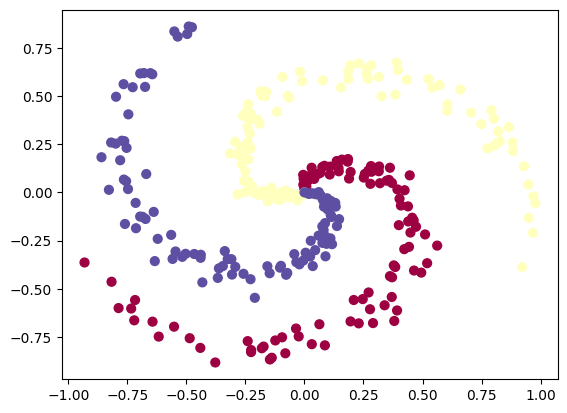

In [205]:
# Code for creating a spiral dataset from CS231n
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [206]:
print(f"The first 5 values of X \n{X[:5]}")
print(f"\nThe first 5 values of y {y[:5]}")
print(f"\nThe X are the values of X, while y is the label. There are two values of X and 3 possible labels for X (given by y)")

The first 5 values of X 
[[ 0.          0.        ]
 [-0.00168595  0.00995932]
 [ 0.00041548  0.02019775]
 [ 0.00793629  0.02924532]
 [-0.00490931  0.04010468]]

The first 5 values of y [0 0 0 0 0]

The X are the values of X, while y is the label. There are two values of X and 3 possible labels for X (given by y)


In [207]:
# Checking types of X and y
# Will need to convert into tensor then doing training and tests splits
X_check = X[0]
y_check = y[0]
print(f"X type is {type(X_check)}")
print(f"y type is {type(y_check)}")

X type is <class 'numpy.ndarray'>
y type is <class 'numpy.uint8'>


In [208]:
X_tensor = torch.from_numpy(X).type(torch.float32)
y_tensor = torch.from_numpy(y).type(torch.LongTensor)
X_tensor[:2], y_tensor[:2]

(tensor([[ 0.0000,  0.0000],
         [-0.0017,  0.0100]]),
 tensor([0, 0]))

In [209]:
# Ensuring that the tensors are the correct type and dim
print(f"The data type of X_tensor is {X_tensor.dtype}")
print(f"The data type of y_tensor is {y_tensor.dtype}")
print(f"The dim of X_tensor is {X_tensor.ndim}")
print(f"The dim of y_tensor is {y_tensor.ndim}")

The data type of X_tensor is torch.float32
The data type of y_tensor is torch.int64
The dim of X_tensor is 2
The dim of y_tensor is 1


In [210]:
# Spliting the data with a training 80% split, and testing 20%.
X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size =.155
)
# X_Train is the training values, & y_train is the corrisponding labels for the training data
# X_test is the testing values, & y_test is the corrisponding labels for the testing data
len(X_train), len(y_train), len(X_test), len(y_test)

(253, 253, 47, 47)

In [211]:
# Agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Creating model
- When creating this model i'll go back and fine tune the model to ensure the best model. However I will not show the different models to see the differeces of fine tuning different models for outcomes check out my repo on binary classifications using make_moons from sklearn
- https://github.com/Sunny-tries/Deep-learing-Machine-Learning/blob/main/make_moons_binary_classification.ipynb

In [212]:
# Creating model
in_features = 2
hidden_features = 18
output_features = 3

class spiralModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [213]:
model = spiralModel()
model

spiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=18, bias=True)
    (3): ReLU()
    (4): Linear(in_features=18, out_features=18, bias=True)
    (5): ReLU()
    (6): Linear(in_features=18, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=18, bias=True)
    (9): ReLU()
    (10): Linear(in_features=18, out_features=3, bias=True)
  )
)

In [214]:
y_logits_pretrained = model(X_train)
y_logits_pretrained[:5], y_train[:5]

(tensor([[-0.0368,  0.1259, -0.0208],
         [-0.0331,  0.1240, -0.0160],
         [-0.0347,  0.1248, -0.0177],
         [-0.0352,  0.1248, -0.0184],
         [-0.0325,  0.1238, -0.0156]], grad_fn=<SliceBackward0>),
 tensor([0, 1, 0, 1, 1]))

In [215]:
# Creating loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr = .15)

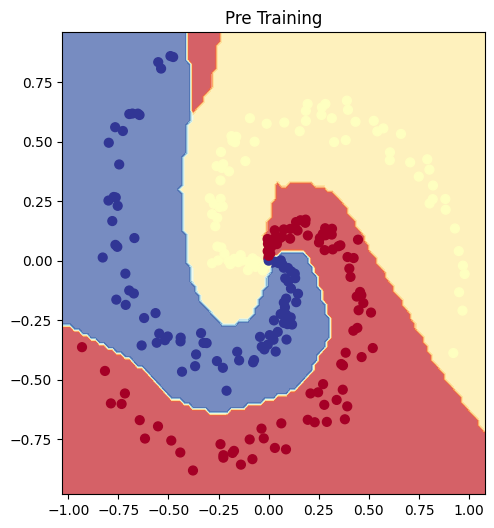

In [219]:
# Plotting the pre trained model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Pre Training")
plot_decision_boundary(model, X_train, y_train)

In [217]:
# Training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1001

for epoch in range(epochs):
  model.train()
  y_logits = model(X_train)

  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  with torch.inference_mode():
    test_logits = model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    # Printing Epochs
    if epoch % 50 == 0:
       print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1038, Acc: 32.02% | Test Loss: 1.0914, Test acc: 40.43%
Epoch: 50 | Loss: 1.0977, Acc: 34.39% | Test Loss: 1.1032, Test acc: 27.66%
Epoch: 100 | Loss: 1.0969, Acc: 34.39% | Test Loss: 1.1026, Test acc: 27.66%
Epoch: 150 | Loss: 1.0954, Acc: 34.39% | Test Loss: 1.1011, Test acc: 27.66%
Epoch: 200 | Loss: 1.0914, Acc: 34.39% | Test Loss: 1.0974, Test acc: 27.66%
Epoch: 250 | Loss: 1.0713, Acc: 48.62% | Test Loss: 1.0784, Test acc: 42.55%
Epoch: 300 | Loss: 0.9293, Acc: 51.78% | Test Loss: 0.9430, Test acc: 51.06%
Epoch: 350 | Loss: 0.9071, Acc: 56.52% | Test Loss: 0.9778, Test acc: 63.83%
Epoch: 400 | Loss: 0.8166, Acc: 60.47% | Test Loss: 0.8891, Test acc: 70.21%
Epoch: 450 | Loss: 0.7050, Acc: 64.03% | Test Loss: 0.7131, Test acc: 72.34%
Epoch: 500 | Loss: 0.6002, Acc: 73.12% | Test Loss: 0.5783, Test acc: 78.72%
Epoch: 550 | Loss: 0.5513, Acc: 77.87% | Test Loss: 0.6179, Test acc: 78.72%
Epoch: 600 | Loss: 0.7022, Acc: 68.38% | Test Loss: 0.9761, Test acc: 63.83%
Ep

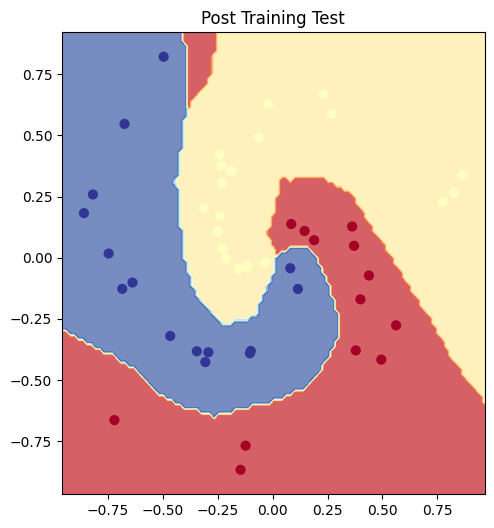

In [220]:
# Plotting the pre trained model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Post Training Test")
plot_decision_boundary(model, X_test, y_test)